![alt text](https://drive.google.com/uc?export=view&id=1UXScsVx_Wni_JuDdB8LeTnM6jsPfIwkW)

Proprietary content. © Great Learning. All Rights Reserved. Unauthorized use or distribution prohibited.

# Face Mask Prediction using U-Net
Task is to predict the mask around the face in a given image.

# Instructions
- Some part of the code is already done for you
- You need to execute all the cells
- You need to add the code where ever you see `"#### Add your code here ####"`
- Marks are mentioned along with the cells

## Dataset
Faces in images marked with bounding boxes. Have around 409 images with around 1000 faces manually tagged via bounding box.
- Data file name: images.npy

###### Importing necessary packages

In [1]:
import numpy as np
import cv2
import tensorflow as tf
from PIL import Image
from tensorflow.keras import Model
from tensorflow.keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Concatenate, Conv2D, UpSampling2D, Reshape

### Mount Google drive if you are using google colab
- We recommend using Google Colab as you can face memory issues and longer runtimes while running on local

In [2]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/MyDrive/

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/MyDrive


### Load the "images.npy" file (2 marks)
- This file contains images with details of bounding boxes

##### Loading the file 

In [3]:
data = np.load('images.npy',allow_pickle=True)

### Check one sample from the loaded "images.npy" file  (2 marks)
- Hint: print data[10][1] 

In [4]:
data[10][1]

[{'imageHeight': 337,
  'imageWidth': 600,
  'label': ['Face'],
  'notes': '',
  'points': [{'x': 0.48, 'y': 0.10385756676557864},
   {'x': 0.7716666666666666, 'y': 0.6795252225519288}]}]

### Set image dimensions   (1 mark)
- Initialize image height, image width with value: 224 

In [5]:
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224

### Create features and labels
- Here feature is the image
- The label is the mask
- Images will be stored in "X" array
- Masks will be stored in "masks" array

In [6]:
masks = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))
X = np.zeros((int(data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH, 3))
for index in range(data.shape[0]):
    img = data[index][0]
    img = cv2.resize(img, dsize=(IMAGE_HEIGHT, IMAGE_WIDTH), interpolation=cv2.INTER_CUBIC)
    try:
      img = img[:, :, :3]
    except:
      continue
    X[index] = preprocess_input(np.array(img, dtype=np.float32))
    for i in data[index][1]:
        x1 = int(i["points"][0]['x'] * IMAGE_WIDTH)
        x2 = int(i["points"][1]['x'] * IMAGE_WIDTH)
        y1 = int(i["points"][0]['y'] * IMAGE_HEIGHT)
        y2 = int(i["points"][1]['y'] * IMAGE_HEIGHT)
        masks[index][y1:y2, x1:x2] = 1

In [7]:
X.shape

(409, 224, 224, 3)

##### preprocessing masks

In [8]:
masks1 = []
for mask in masks:
  masks1.append(cv2.resize(mask, (28, 28)))
masks1 = np.array(masks1)
masks1.shape

(409, 28, 28)

### Split the data into training and testing (2 marks)
- 400 images in training
- 9 images in testing data

#### Training data

In [9]:
X_train = X[:-9]
y_train = masks1[:-9]

##### Testing data

In [10]:
X_test = X[-9:]
y_test = masks1[-9:]

### Print a sample training image, image array and its mask (2 marks)

##### Print the image and image array

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


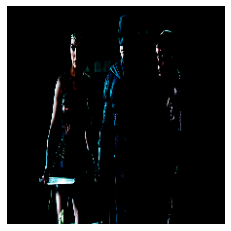

Image Array : 
 [[[-0.83529413 -0.72549021 -0.65490198]
  [-0.82745099 -0.70980394 -0.63921571]
  [-0.81176472 -0.68627453 -0.62352943]
  ...
  [-0.87450981 -0.81960785 -0.77254903]
  [-0.87450981 -0.81960785 -0.75686276]
  [-0.86666667 -0.79607844 -0.73333335]]

 [[-0.8509804  -0.7019608  -0.65490198]
  [-0.8509804  -0.7019608  -0.65490198]
  [-0.83529413 -0.68627453 -0.63921571]
  ...
  [-0.86666667 -0.81176472 -0.7647059 ]
  [-0.84313726 -0.78823531 -0.72549021]
  [-0.83529413 -0.7647059  -0.70980394]]

 [[-0.84313726 -0.67843139 -0.63921571]
  [-0.83529413 -0.67058825 -0.63137257]
  [-0.84313726 -0.67843139 -0.63921571]
  ...
  [-0.85882354 -0.80392158 -0.75686276]
  [-0.81960785 -0.7647059  -0.70980394]
  [-0.81176472 -0.74117649 -0.68627453]]

 ...

 [[-0.71764708 -0.59215689 -0.52941179]
  [-0.7019608  -0.57647061 -0.51372552]
  [-0.69411767 -0.59215689 -0.52156866]
  ...
  [-0.90588236 -0.81960785 -0.77254903]
  [-0.9137255  -0.82745099 -0.78039217]
  [-0.90588236 -0.81960785 -

In [11]:
import matplotlib.pyplot as plt
plt.imshow(X_train[15])
plt.axis('off')
plt.show()
print('Image Array : \n',X_train[15])

#### Print the mask

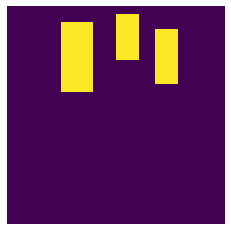

In [12]:
plt.imshow(y_train[15])
plt.axis('off')
plt.show()

## Create the model (5 marks)
- Add MobileNet as model with below parameter values
  - input_shape: IMAGE_HEIGHT, IMAGE_WIDTH, 3
  - include_top: False
  - alpha: 1.0
  - weights: "imagenet"
- Add UNET architecture layers
  - This is the trickiest part of the project, you need to research and implement it correctly

In [13]:
ALPHA = 1.0
def create_model(trainable=True):
    model = MobileNet(input_shape=(IMAGE_HEIGHT, IMAGE_WIDTH, 3), include_top=False, alpha=ALPHA, weights="imagenet")

    for layer in model.layers:
        layer.trainable = trainable

    block1 = model.get_layer("conv_pw_5_relu").output
    block2 = model.get_layer("conv_pw_11_relu").output
    block3 = model.get_layer("conv_pw_13_relu").output

    x = Concatenate()([UpSampling2D()(block3), block2])
    x = Concatenate()([UpSampling2D()(x), block1])

    x = Conv2D(1, kernel_size=1, activation="sigmoid")(x)
    x = Reshape((28,28))(x)

    return Model(inputs=model.input, outputs=x)

### Call the create_model function (1 mark)
- Give trainable=False as argument, if you want to freeze lower layers for fast training (but low accuracy)

In [14]:
model = create_model(trainable = False)

### Print model summary (1 mark)

In [15]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 32) 128         conv1[0][0]                      
__________________________________________________________________________________________________
conv1_relu (ReLU)               (None, 112, 112, 32) 0           conv1_bn[0][0]                   
______________________________________________________________________________________________

### Define dice coefficient function (2 marks)
- Create a function to calculate dice coefficient


##### Dice Coefficient

In [16]:
def dice_coefficient(y_true, y_pred):
    numerator = 2 * tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true + y_pred)
    return numerator / (denominator + tf.keras.backend.epsilon())

### Define loss function (2 marks)

In [17]:
import tensorflow as tf
def loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) - tf.math.log(dice_coefficient(y_true, y_pred) + tf.keras.backend.epsilon())

### Compile the model (2 marks)
- Complie the model using below parameters
  - loss: use the loss function defined above
  - optimizers: use Adam optimizer
  - metrics: use dice_coefficient function defined above

##### Compile Model

In [18]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
optimizer = Adam(lr=1e-4, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss=loss, optimizer='adam', metrics=[dice_coefficient])

### Define callbacks (2 marks)
- Use ModelCheckpoint
- Use EarlyStopping
- Use ReduceLROnPlateau

In [19]:
checkpoint = ModelCheckpoint("model-{val_loss:.2f}.h5", monitor="val_loss", verbose=1, save_best_only=True,
                             save_weights_only=True, mode="auto", period=1)
stop = EarlyStopping(monitor="val_loss", patience=10, mode="auto")
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=5, min_lr=1e-6, verbose=1, mode="auto")

### Fit the model (2 marks)
- Fit the model using below parameters
  - epochs: you can decide
  - batch_size: 1
  - callbacks: use the callbacks defined above

In [20]:
model.fit(X_train,y_train,
                    epochs=20,
                    batch_size = 1,
                    validation_data=(X_test,y_test),
                    callbacks=[checkpoint, reduce_lr, stop],
                    use_multiprocessing=False,
                    shuffle=True,verbose=1)

Epoch 1/20
400/400 [==============================] - 6s 7ms/step - loss: 1.4023 - dice_coefficient: 0.4200 - val_loss: 0.8432 - val_dice_coefficient: 0.5462

Epoch 00001: val_loss improved from inf to 0.84320, saving model to model-0.84.h5
Epoch 2/20
400/400 [==============================] - 2s 5ms/step - loss: 0.8692 - dice_coefficient: 0.5829 - val_loss: 0.8299 - val_dice_coefficient: 0.5499

Epoch 00002: val_loss improved from 0.84320 to 0.82987, saving model to model-0.83.h5
Epoch 3/20
400/400 [==============================] - 2s 5ms/step - loss: 0.7814 - dice_coefficient: 0.6062 - val_loss: 0.8521 - val_dice_coefficient: 0.5425

Epoch 00003: val_loss did not improve from 0.82987
Epoch 4/20
400/400 [==============================] - 2s 5ms/step - loss: 0.7517 - dice_coefficient: 0.6226 - val_loss: 0.9183 - val_dice_coefficient: 0.5239

Epoch 00004: val_loss did not improve from 0.82987
Epoch 5/20
400/400 [==============================] - 2s 5ms/step - loss: 0.7851 - dice_coeffi

### Get the predicted mask for a test image   (2 marks)

#### Test Image

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


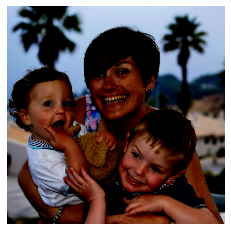

In [21]:
import matplotlib.pyplot as plt
plt.imshow(X_test[0])
plt.axis('off')
plt.show()

Show original mask for test image

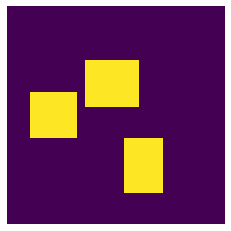

In [22]:
plt.imshow(y_test[0])
plt.axis('off')
plt.show()

Predict the mask on the test image

(-0.5, 27.5, 27.5, -0.5)

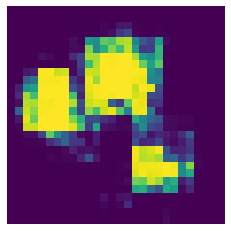

In [23]:
mask_predicted = model.predict(X_test)
plt.imshow(mask_predicted[0])
plt.axis('off')

### Impose the mask on the test image (2 marks)
- In imshow use the alpha parameter and set it to greater than 0.5

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Original Mask imposed Image :


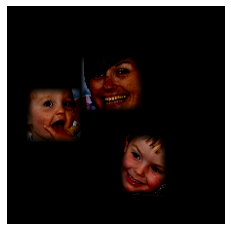

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).



Predicted Mask imposed Image :


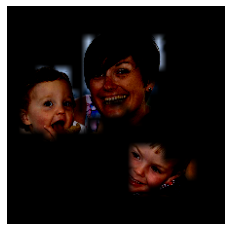

In [24]:
mask = cv2.resize(1.0*(mask_predicted[0]>0.5),(IMAGE_HEIGHT,IMAGE_WIDTH))
mask_original = cv2.resize(1.0*(y_test[0]>0.5),(IMAGE_HEIGHT,IMAGE_WIDTH))
print('\nOriginal Mask imposed Image :')
original = X_test[0].copy()
original[:,:,0] = mask_original*original[:,:,0]
original[:,:,1] = mask_original*original[:,:,1]
original[:,:,2] = mask_original*original[:,:,2]
plt.imshow(original)
plt.axis('off')
plt.show()
image = X_test[0]
image[:,:,0] = mask*image[:,:,0]
image[:,:,1] = mask*image[:,:,1]
image[:,:,2] = mask*image[:,:,2]
print('\nPredicted Mask imposed Image :')
plt.imshow(image)
plt.axis('off')
plt.show()

##### From the above cell output we can observe that our model has done a good job in predicting the face mask on the test images.